# **Exploratory Analysis**

This notebook focuses on some exploratory data analysis and tries to find the answers to the following questions:

 - What is the impact of each marketing strategy on **Conversion Rate** and **Return of Interest (ROI)**?
 - Is the same strategy valid for all the different **Customer Segments**?

# **Read Data from Bigquery**

In [ ]:
# Libraries we need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

from google.cloud import bigquery
from google.colab import auth

# Authenticate
auth.authenticate_user()

# Initialize the client for BigQuery
project_id = 'marketing-campaign-449808'
client = bigquery.Client(project=project_id, location='US')

# Get the dataset
dataset_ref = client.dataset(dataset_id='campaign_data', project=project_id)
dataset = client.get_dataset(dataset_ref=dataset_ref)

# Get the table
table_ref = dataset.table('marketing_campaign_dataset')
table = client.get_table(table_ref)
table.schema

[SchemaField('Campaign_ID', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('Company', 'STRING', 'NULLABLE', None, None, (), None),
 SchemaField('Campaign_Type', 'STRING', 'NULLABLE', None, None, (), None),
 SchemaField('Target_Audience', 'STRING', 'NULLABLE', None, None, (), None),
 SchemaField('Duration_Days', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('Channel_Used', 'STRING', 'NULLABLE', None, None, (), None),
 SchemaField('Conversion_Rate', 'FLOAT', 'NULLABLE', None, None, (), None),
 SchemaField('Acquisition_Cost_dollars', 'FLOAT', 'NULLABLE', None, None, (), None),
 SchemaField('ROI', 'FLOAT', 'NULLABLE', None, None, (), None),
 SchemaField('Location', 'STRING', 'NULLABLE', None, None, (), None),
 SchemaField('Language', 'STRING', 'NULLABLE', None, None, (), None),
 SchemaField('Clicks', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('Impressions', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('Engagement_Score', 'INTEGER', 'NU

In [ ]:
# convert to dataframe
df = client.list_rows(table = table).to_dataframe()
df.head()

,Campaign_ID,Company,Campaign_Type,Target_Audience,Duration_Days,Channel_Used,Conversion_Rate,Acquisition_Cost_dollars,ROI,Location,Language,Clicks,Impressions,Engagement_Score,Customer_Segment,Date,Year,Month
0,2921,Alpha Innovations,Influencer,Women 25-34,45,Facebook,0.09,10950.0,6.22,Chicago,English,779,3433,1,Foodies,2021-01-01,2021,January
1,14236,TechCorp,Email,Women 35-44,30,Google Ads,0.07,19789.0,7.01,Houston,German,543,9792,1,Tech Enthusiasts,2021-01-01,2021,January
2,22996,NexGen Systems,Search,Men 25-34,60,Instagram,0.07,11033.0,6.55,New York,English,563,4355,1,Fashionistas,2021-01-01,2021,January
3,24091,Innovate Industries,Search,Men 18-24,60,Email,0.08,16619.0,4.29,New York,French,796,6013,1,Fashionistas,2021-01-01,2021,January
4,27011,Innovate Industries,Social Media,Men 25-34,60,Facebook,0.07,15412.0,2.44,New York,French,847,4625,1,Fashionistas,2021-01-01,2021,January


# **Data Analysis**

In [ ]:
# Check the shape
df.shape

(200000, 18)

## **Analyze the Categorical Columns**

In [ ]:
# Find the total number of Companies
print(f"Total number of companies are: {df['Company'].nunique()}")

Total number of companies are: 5


In [ ]:
# Find the unique values and their count of the categorical columns
for col in df.select_dtypes(include=['object']).columns:
  print(f"""Total number of unique values of {col} column is: {df[col].nunique()}\nValues distribution is:\n{df[col].value_counts(normalize=True)}\n""")

Total number of unique values of Company column is: 5
Values distribution is:
Company
TechCorp               0.201185
Alpha Innovations      0.200255
DataTech Solutions     0.200060
NexGen Systems         0.199955
Innovate Industries    0.198545
Name: proportion, dtype: float64

Total number of unique values of Campaign_Type column is: 5
Values distribution is:
Campaign_Type
Influencer      0.200845
Search          0.200785
Display         0.199935
Email           0.199350
Social Media    0.199085
Name: proportion, dtype: float64

Total number of unique values of Target_Audience column is: 5
Values distribution is:
Target_Audience
Men 18-24      0.201290
Men 25-34      0.200115
All Ages       0.200095
Women 25-34    0.200065
Women 35-44    0.198435
Name: proportion, dtype: float64

Total number of unique values of Channel_Used column is: 6
Values distribution is:
Channel_Used
Email         0.167995
Google Ads    0.167190
Instagram     0.166960
YouTube       0.166960
Website       0.166

## **Analyze the Numeric Columns**

In [ ]:
# Drop ID column
df.drop('Campaign_ID', axis = 1, inplace = True)

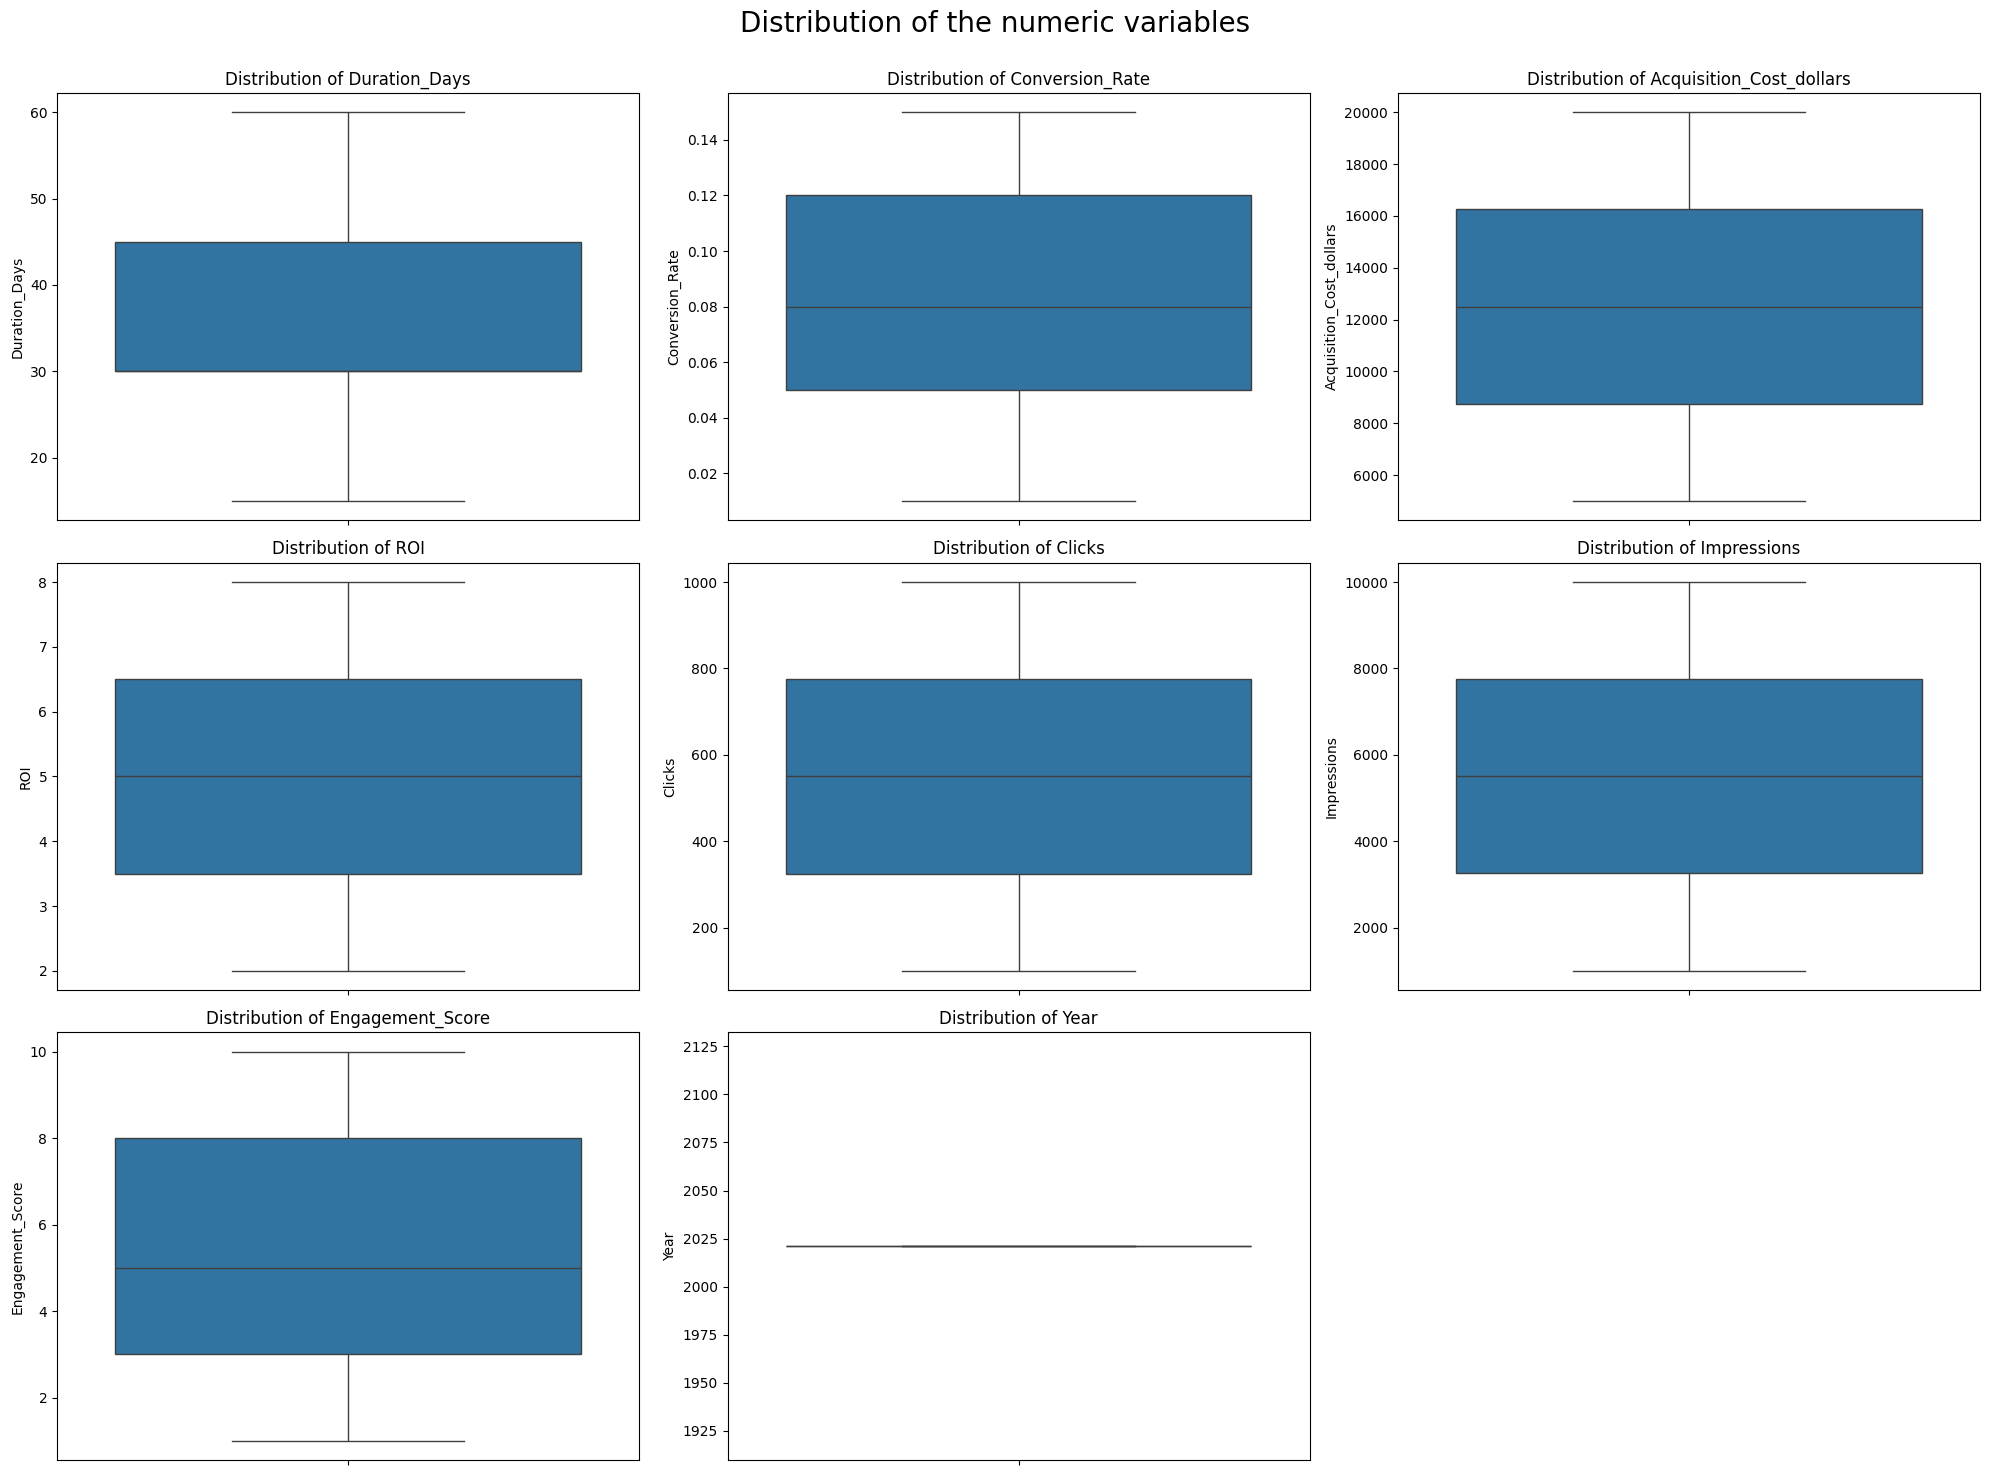

In [ ]:
# Distribution of the numeric variables

# Select numerical columns
num_cols = df.select_dtypes(include=np.number).columns

# Create a 3x3 subplot layout
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))

# Flatten axes for easier iteration
axes = axes.flatten()

# Plot boxplots for each numerical column
for i, col in enumerate(num_cols):
    sns.boxplot(data=df, y=col, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")

# Hide any empty subplots if there are fewer than 9 numerical columns
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle(f"Distribution of the numeric variables\n", fontsize=20)
plt.tight_layout()
plt.show()

The boxplots show the distribution of numeric variables. Most variables have a fairly symmetric spread, with some showing slight skewness. The `Year` variable appears to have an issue, possibly incorrect values. No extreme outliers are evident in other variables.

In [ ]:
# Check out the year column
df['Year'].value_counts()

,count
Year,
2021,200000


## **Data Summary**

In [ ]:
# Grouping data by multiple categorical columns and calculating the mean of numerical columns
data_summary = df.groupby(
    ['Date', 'Company', 'Target_Audience', 'Location', 'Language', 'Customer_Segment', 'Campaign_Type', 'Channel_Used'])\
     [df.select_dtypes(include=np.number).columns].mean().round(3)

# Dropping the 'Year' column from the summary dataset
data_summary.drop('Year', axis=1, inplace=True)
data_summary

Duration_Days  \
Date       Company           Target_Audience Location Language Customer_Segment    Campaign_Type Channel_Used                  
2021-01-01 Alpha Innovations All Ages        Chicago  English  Outdoor Adventurers Search        Instagram              60.0   
                                                      French   Fashionistas        Social Media  Email                  60.0   
                                                               Outdoor Adventurers Display       Instagram              15.0   
                                                      German   Fashionistas        Social Media  Website                45.0   
                                                      Spanish  Foodies             Email         Instagram              60.0   
...                                                                                                                      ...   
2021-12-31 TechCorp          Women 35-44     New York German   Fashionistas        Email         Instagram              15.0   
                                                               Health & Wellness   Display       Facebook               45.0   
                                                               Tech Enthusiasts    Influencer    Instagram              60.0   
                                                      Mandarin Health & Wellness   Influencer    YouTube                45.0   
                                                               Tech Enthusiasts    Search        Email                  30.0   

                                                                                                               Conversion_Rate  \
Date       Company           Target_Audience Location Language Customer_Segment    Campaign_Type Channel_Used                    
2021-01-01 Alpha Innovations All Ages        Chicago  English  Outdoor Adventurers Search        Instagram                0.06   
                                                      French   Fashionistas        Social Media  Email                    0.12   
                                                               Outdoor Adventurers Display       Instagram                0.06   
                                                      German   Fashionistas        Social Media  Website                  0.06   
                                                      Spanish  Foodies             Email         Instagram                0.14   
...                                                                                                                        ...   
2021-12-31 TechCorp          Women 35-44     New York German   Fashionistas        Email         Instagram                0.01   
                                                               Health & Wellness   Display       Facebook                 0.10   
                                                               Tech Enthusiasts    Influencer    Instagram                0.12   
                                                      Mandarin Health & Wellness   Influencer    YouTube                  0.14   
                                                               Tech Enthusiasts    Search        Email                    0.10   

                                                                                                               Acquisition_Cost_dollars  \
Date       Company           Target_Audience Location Language Customer_Segment    Campaign_Type Channel_Used                             
2021-01-01 Alpha Innovations All Ages        Chicago  English  Outdoor Adventurers Search        Instagram                       8702.0   
                                                      French   Fashionistas        Social Media  Email                           5280.0   
                                                               Outdoor Adventurers Display       Instagram                       7096.0   
                                                      German

**The output will be analyzed in the Power BI report.**

## **Consolidated Strategy for Targeting**

### **Encode the Categorical Columns to Get the Impact on the Desired Metrics**

In [ ]:
# One hot for the categorical columns.
df_encode = df.copy()

# Drop 'Date', 'Year', and 'Month' columns
df_encode = df_encode.drop(['Date', 'Year', 'Month'], axis=1)

# Apply one-hot encoding
df_encode = pd.get_dummies(df_encode).astype(np.float64)
df_encode.head()

,Duration_Days,Conversion_Rate,Acquisition_Cost_dollars,ROI,Clicks,Impressions,Engagement_Score,Company_Alpha Innovations,Company_DataTech Solutions,Company_Innovate Industries,Company_NexGen Systems,Company_TechCorp,Campaign_Type_Display,Campaign_Type_Email,Campaign_Type_Influencer,Campaign_Type_Search,Campaign_Type_Social Media,Target_Audience_All Ages,Target_Audience_Men 18-24,Target_Audience_Men 25-34,Target_Audience_Women 25-34,Target_Audience_Women 35-44,Channel_Used_Email,Channel_Used_Facebook,Channel_Used_Google Ads,Channel_Used_Instagram,Channel_Used_Website,Channel_Used_YouTube,Location_Chicago,Location_Houston,Location_Los Angeles,Location_Miami,Location_New York,Language_English,Language_French,Language_German,Language_Mandarin,Language_Spanish,Customer_Segment_Fashionistas,Customer_Segment_Foodies,Customer_Segment_Health & Wellness,Customer_Segment_Outdoor Adventurers,Customer_Segment_Tech Enthusiasts
0,45.0,0.09,10950.0,6.22,779.0,3433.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,30.0,0.07,19789.0,7.01,543.0,9792.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,60.0,0.07,11033.0,6.55,563.0,4355.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,60.0,0.08,16619.0,4.29,796.0,6013.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,60.0,0.07,15412.0,2.44,847.0,4625.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
df_encode.columns

Index(['Duration_Days', 'Conversion_Rate', 'Acquisition_Cost_dollars', 'ROI',
       'Clicks', 'Impressions', 'Engagement_Score',
       'Company_Alpha Innovations', 'Company_DataTech Solutions',
       'Company_Innovate Industries', 'Company_NexGen Systems',
       'Company_TechCorp', 'Campaign_Type_Display', 'Campaign_Type_Email',
       'Campaign_Type_Influencer', 'Campaign_Type_Search',
       'Campaign_Type_Social Media', 'Target_Audience_All Ages',
       'Target_Audience_Men 18-24', 'Target_Audience_Men 25-34',
       'Target_Audience_Women 25-34', 'Target_Audience_Women 35-44',
       'Channel_Used_Email', 'Channel_Used_Facebook',
       'Channel_Used_Google Ads', 'Channel_Used_Instagram',
       'Channel_Used_Website', 'Channel_Used_YouTube', 'Location_Chicago',
       'Location_Houston', 'Location_Los Angeles', 'Location_Miami',
       'Location_New York', 'Language_English', 'Language_French',
       'Language_German', 'Language_Mandarin', 'Language_Spanish',
       'Custome

### **Correlation with the Conversion Rate (Marketing Strategy Impact on Conversion Rate)**

In [ ]:
# Creating a green color gradient for better visualization
cm = sns.light_palette("green", as_cmap=True)

# Calculating correlation between 'Conversion_Rate' and encoded marketing strategy variables
correlation_analysis_cr = pd.DataFrame(df_encode[['Conversion_Rate',
                                                  'Campaign_Type_Display', 'Campaign_Type_Email', 'Campaign_Type_Influencer', 'Campaign_Type_Search',
                                                  'Campaign_Type_Social Media', 'Channel_Used_Email', 'Channel_Used_Facebook',
                                                  'Channel_Used_Google Ads', 'Channel_Used_Instagram', 'Channel_Used_Website', 'Channel_Used_YouTube']]\
                                                  .corr()['Conversion_Rate']).reset_index()

# Renaming columns for better readability
correlation_analysis_cr.columns = ['Impacting_Variable','Impact']

# Removing 'Conversion_Rate' itself from the correlation table
correlation_analysis_cr=correlation_analysis_cr[correlation_analysis_cr['Impacting_Variable']!='Conversion_Rate']

# Sorting variables based on the degree of correlation
correlation_analysis_cr = correlation_analysis_cr.sort_values('Impact',ascending=False).reset_index(drop=True)

# Applying a gradient color style and formatting the correlation values
correlation_analysis_cr.style.background_gradient(cmap=cm).format(precision=4)

,Impacting_Variable,Impact
0,Campaign_Type_Influencer,0.0030
1,Channel_Used_Email,0.0023
2,Channel_Used_Google Ads,0.0013
3,Channel_Used_Website,0.0012
4,Campaign_Type_Social Media,0.0008
5,Campaign_Type_Display,0.0002
6,Campaign_Type_Search,-0.0006
7,Channel_Used_Facebook,-0.0008
8,Channel_Used_YouTube,-0.0020
9,Channel_Used_Instagram,-0.0020


### **Correlation with the ROI (Marketing Strategy Impact on  ROI)**

In [ ]:
cm = sns.light_palette("green", as_cmap=True)

# Calculating correlation between 'ROI' and encoded marketing strategy variables
correlation_analysis_roi = pd.DataFrame(df_encode[['ROI',
                                                  'Campaign_Type_Display', 'Campaign_Type_Email', 'Campaign_Type_Influencer', 'Campaign_Type_Search',
                                                  'Campaign_Type_Social Media', 'Channel_Used_Email', 'Channel_Used_Facebook',
                                                  'Channel_Used_Google Ads', 'Channel_Used_Instagram', 'Channel_Used_Website', 'Channel_Used_YouTube']]\
                                                  .corr()['ROI']).reset_index()

correlation_analysis_roi.columns = ['Impacting_Variable','Impact']
correlation_analysis_roi = correlation_analysis_roi[correlation_analysis_roi['Impacting_Variable']!='ROI']
correlation_analysis_roi = correlation_analysis_roi.sort_values('Impact',ascending=False).reset_index(drop=True)
correlation_analysis_roi.style.background_gradient(cmap=cm).format(precision=4)

,Impacting_Variable,Impact
0,Channel_Used_Facebook,0.0042
1,Channel_Used_Website,0.0030
2,Campaign_Type_Influencer,0.0025
3,Campaign_Type_Search,0.0017
4,Campaign_Type_Display,0.0012
5,Channel_Used_Google Ads,0.0002
6,Channel_Used_Email,-0.0015
7,Channel_Used_YouTube,-0.0022
8,Campaign_Type_Email,-0.0023
9,Campaign_Type_Social Media,-0.0031


### **Correlation with the Conversion Rate (Marketing Strategy Impact on Conversion Rate Breakdown by Customer Segment)**

In [ ]:
df.columns

Index(['Company', 'Campaign_Type', 'Target_Audience', 'Duration_Days',
       'Channel_Used', 'Conversion_Rate', 'Acquisition_Cost_dollars', 'ROI',
       'Location', 'Language', 'Clicks', 'Impressions', 'Engagement_Score',
       'Customer_Segment', 'Date', 'Year', 'Month'],
      dtype='object')

In [ ]:
# One hot for the categorical columns.
df_encode_2 = df.copy()

# Drop 'Date', 'Year', and 'Month' columns
df_encode_2 = df_encode_2.drop(['Date', 'Year', 'Month'], axis=1)

# Identify categorical columns (excluding 'Customer_Segment')
categorical_cols = df_encode_2.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_cols.remove('Customer_Segment')  # Exclude 'Customer_Segment' from encoding

# Apply one-hot encoding only to selected categorical columns
df_encode_2 = pd.get_dummies(df_encode_2, columns=categorical_cols, dtype=np.float64)
df_encode_2.head()

,Duration_Days,Conversion_Rate,Acquisition_Cost_dollars,ROI,Clicks,Impressions,Engagement_Score,Customer_Segment,Company_Alpha Innovations,Company_DataTech Solutions,Company_Innovate Industries,Company_NexGen Systems,Company_TechCorp,Campaign_Type_Display,Campaign_Type_Email,Campaign_Type_Influencer,Campaign_Type_Search,Campaign_Type_Social Media,Target_Audience_All Ages,Target_Audience_Men 18-24,Target_Audience_Men 25-34,Target_Audience_Women 25-34,Target_Audience_Women 35-44,Channel_Used_Email,Channel_Used_Facebook,Channel_Used_Google Ads,Channel_Used_Instagram,Channel_Used_Website,Channel_Used_YouTube,Location_Chicago,Location_Houston,Location_Los Angeles,Location_Miami,Location_New York,Language_English,Language_French,Language_German,Language_Mandarin,Language_Spanish
0,45,0.09,10950.0,6.22,779,3433,1,Foodies,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,30,0.07,19789.0,7.01,543,9792,1,Tech Enthusiasts,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,60,0.07,11033.0,6.55,563,4355,1,Fashionistas,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,60,0.08,16619.0,4.29,796,6013,1,Fashionistas,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,60,0.07,15412.0,2.44,847,4625,1,Fashionistas,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
cm = sns.light_palette("green", as_cmap=True)

# Grouping data by 'Customer_Segment' and calculating correlation with 'Conversion_Rate'
correlation_analysis_cr_cs = pd.DataFrame(df_encode_2.groupby('Customer_Segment')[['Conversion_Rate',
                                                  'Campaign_Type_Display', 'Campaign_Type_Email', 'Campaign_Type_Influencer', 'Campaign_Type_Search',
                                                  'Campaign_Type_Social Media', 'Channel_Used_Email', 'Channel_Used_Facebook',
                                                  'Channel_Used_Google Ads', 'Channel_Used_Instagram', 'Channel_Used_Website', 'Channel_Used_YouTube']]\
                                                  .corr()['Conversion_Rate']).reset_index()

# Sorting values first by 'Customer_Segment' and then by correlation strength
correlation_analysis_cr_cs = correlation_analysis_cr_cs.sort_values(['Customer_Segment', 'Conversion_Rate'],ascending=False)
correlation_analysis_cr_cs.columns = ['Customer_Segment', 'Impacting_Variable', 'Impact']
correlation_analysis_cr_cs = correlation_analysis_cr_cs[correlation_analysis_cr_cs['Impacting_Variable']!='Conversion_Rate'].reset_index(drop=True)
correlation_analysis_cr_cs.style.background_gradient(cmap=cm).format(precision=4)

,Customer_Segment,Impacting_Variable,Impact
0,Tech Enthusiasts,Campaign_Type_Email,0.0092
1,Tech Enthusiasts,Channel_Used_Website,0.0078
2,Tech Enthusiasts,Campaign_Type_Influencer,0.0069
3,Tech Enthusiasts,Channel_Used_YouTube,0.0040
4,Tech Enthusiasts,Channel_Used_Email,0.0030
5,Tech Enthusiasts,Channel_Used_Facebook,-0.0020
6,Tech Enthusiasts,Campaign_Type_Search,-0.0046
7,Tech Enthusiasts,Campaign_Type_Social Media,-0.0050
8,Tech Enthusiasts,Channel_Used_Instagram,-0.0055
9,Tech Enthusiasts,Campaign_Type_Display,-0.0066


### **Correlation with the ROI (Marketing Strategy Impact on ROI breakdown by Customer Segment)**

In [ ]:
cm = sns.light_palette("green", as_cmap=True)

# Grouping data by 'Customer_Segment' and calculating correlation with 'ROI'
correlation_analysis_roi_cs = pd.DataFrame(df_encode_2.groupby('Customer_Segment')[['ROI',
                                                  'Campaign_Type_Display', 'Campaign_Type_Email', 'Campaign_Type_Influencer', 'Campaign_Type_Search',
                                                  'Campaign_Type_Social Media', 'Channel_Used_Email', 'Channel_Used_Facebook',
                                                  'Channel_Used_Google Ads', 'Channel_Used_Instagram', 'Channel_Used_Website', 'Channel_Used_YouTube']]\
                                                  .corr()['ROI']).reset_index()
correlation_analysis_roi_cs = correlation_analysis_roi_cs.sort_values(['Customer_Segment', 'ROI'],ascending=False)
correlation_analysis_roi_cs.columns = ['Customer_Segment', 'Impacting_Variable', 'Impact']
correlation_analysis_roi_cs = correlation_analysis_roi_cs[correlation_analysis_roi_cs['Impacting_Variable'] != 'ROI'].reset_index(drop=True)
correlation_analysis_roi_cs.style.background_gradient(cmap=cm).format(precision=4)

,Customer_Segment,Impacting_Variable,Impact
0,Tech Enthusiasts,Channel_Used_Facebook,0.0116
1,Tech Enthusiasts,Campaign_Type_Influencer,0.0075
2,Tech Enthusiasts,Channel_Used_Email,0.0017
3,Tech Enthusiasts,Channel_Used_YouTube,0.0009
4,Tech Enthusiasts,Campaign_Type_Search,-0.0009
5,Tech Enthusiasts,Campaign_Type_Email,-0.0009
6,Tech Enthusiasts,Campaign_Type_Social Media,-0.0020
7,Tech Enthusiasts,Channel_Used_Website,-0.0029
8,Tech Enthusiasts,Channel_Used_Google Ads,-0.0031
9,Tech Enthusiasts,Campaign_Type_Display,-0.0038


### **Summary of EDA Findings**

#### **1. Correlation with Conversion Rate (Marketing Strategy Impact)**
- **Most positive impact**: *Influencer campaigns (0.0030)*, followed by *Email (0.0023)* and *Google Ads (0.0013)*.
- **Negative impact**: *Email campaigns (-0.0035)*, *Instagram (-0.0020)*, *YouTube (-0.0020)*, and *Facebook (-0.0008)*.
- **Key Insight**: **Influencer marketing and email marketing through direct channels (excluding campaigns) perform best, while social media campaigns, particularly Instagram and YouTube, negatively impact conversion.**

#### **2. Correlation with ROI (Marketing Strategy Impact)**
- **Most positive impact**: *Facebook (0.0042)*, *Website (0.0030)*, and *Influencer marketing (0.0025)*.
- **Negative impact**: *Instagram (-0.0035)*, *Social media campaigns (-0.0031)*, and *Email campaigns (-0.0023)*.
- **Key Insight**: **Website traffic, Facebook, and influencer campaigns yield the highest ROI, whereas Instagram and social media campaigns seem to underperform.**

#### **3. Conversion Rate Impact by Customer Segment**
- **Tech Enthusiasts**: Best conversion from *Email campaigns (0.0092)* and *Website traffic (0.0078)*, worst from *Google Ads (-0.0074)* and *Display ads (-0.0066)*.
- **Outdoor Adventurers**: *Google Ads (0.0088)* and *Influencer marketing (0.0061)* work best, while *YouTube (-0.0118)* has a significant negative effect.
- **Health & Wellness**: *Display ads (0.0070)* and *Email (0.0054)* contribute positively, while *Email campaigns (-0.0081)* and *Instagram (-0.0052)* perform poorly.
- **Foodies**: *Google Ads (0.0143)* and *Social media campaigns (0.0100)* work well, but *Facebook (-0.0067)* and *YouTube (-0.0053)* show negative results.
- **Fashionistas**: *Display ads (0.0079)* and *Instagram (0.0060)* contribute positively, while *Email campaigns (-0.0098)* and *Google Ads (-0.0095)* show the worst results.
- **Key Insight**: **Different customer segments respond differently to marketing strategies. Tech Enthusiasts and Health & Wellness segments prefer email marketing and website traffic, while Foodies and Fashionistas engage more with digital ads.**

#### **4. ROI Impact by Customer Segment**
- **Tech Enthusiasts**: *Facebook (0.0116)* and *Influencer campaigns (0.0075)* drive ROI, while *Instagram (-0.0082)* and *Display ads (-0.0038)* hurt performance.
- **Outdoor Adventurers**: *Facebook (0.0060)* and *Display ads (0.0049)* work best, while *Email campaigns (-0.0106)* reduce ROI.
- **Health & Wellness**: *Search ads (0.0071)* and *Email marketing (0.0048)* are strong, while *Instagram (-0.0089)* and *YouTube (-0.0040)* reduce ROI.
- **Foodies**: *Website (0.0075)* and *YouTube (0.0051)* show positive impact, while *Google Ads (-0.0090)* and *Social media campaigns (-0.0079)* hurt ROI.
- **Fashionistas**: *Google Ads (0.0075)* and *Website traffic (0.0051)* contribute to ROI, while *YouTube (-0.0125)* has a significant negative impact.
- **Key Insight**: **ROI patterns align with conversion trends—Tech Enthusiasts and Outdoor Adventurers benefit from influencer and Facebook marketing, while Health & Wellness and Foodies see better ROI from search ads and website traffic.**

### **Overall Key Takeaways**
1. **Influencer and direct email marketing drive conversions across multiple segments.**
2. **Facebook and website traffic provide the best ROI, whereas Instagram and YouTube generally underperform.**
3. **Campaign effectiveness varies significantly by customer segment, requiring tailored strategies.**
4. **Google Ads is inconsistent—working well for some (Foodies, Outdoor Adventurers) but negatively impacting others (Tech Enthusiasts, Fashionistas).**

### Recommendations:

1. **Focus on Influencer Marketing:** It has a positive impact on both conversion rate and ROI, especially for Tech Enthusiasts and Outdoor Adventurers. Invest more in influencer partnerships.

2. **Leverage Email & Website Channels:** Email marketing positively influences conversion rates for certain segments like Tech Enthusiasts and Health & Wellness, while website usage improves ROI.

3. **Prioritize Google Ads for Foodies & Outdoor Adventurers:** Google Ads drive conversion rates for these segments, making it a valuable investment.

4. **Reduce Instagram & YouTube Spending:** These channels negatively impact both conversion rate and ROI across most customer segments.

5. **Optimize Social Media Campaigns:** Social Media campaigns negatively affect ROI and conversion rates for multiple segments. Refine targeting and content strategy before increasing investment.

6. **Increase Facebook & Display Ad Spending for ROI Growth:** Facebook and Display Ads positively impact ROI, especially for Outdoor Adventurers and Fashionistas.

7. **Customize Strategies by Customer Segment:**  
   - **Tech Enthusiasts:** Prioritize influencer marketing, website campaigns, and email marketing.  
   - **Outdoor Adventurers:** Invest in Google Ads, Facebook, and influencer campaigns.  
   - **Health & Wellness:** Use display ads and email marketing while limiting Instagram campaigns.  
   - **Foodies:** Focus on Google Ads and social media, but reduce email campaigns.  
   - **Fashionistas:** Instagram and display ads work well; reduce email and YouTube efforts.  

8. **Refine Search & Display Ad Campaigns:** While search campaigns slightly help ROI, they negatively impact conversion rates for some segments. Optimize targeting and ad creatives.

9. **Test & Adjust Regularly:** Continuously track campaign performance and adjust strategies based on data-driven insights to maximize ROI and conversion rates.

# **Write data on BigQuery**

The aggregated and summarized data will be used in Power BI reporting.

In [ ]:
from pandas_gbq import to_gbq

database_name = 'campaign_data'

data_summary.reset_index(inplace = True)
to_gbq(data_summary, f'{database_name}.summary_dataset', project_id=project_id, chunksize=None, if_exists='replace')
to_gbq(df_encode, f'{database_name}.encoded_dataset', project_id=project_id, chunksize=None, if_exists='replace')
to_gbq(correlation_analysis_cr, f'{database_name}.correlation_with_conversion', project_id=project_id, chunksize=None, if_exists='replace')
to_gbq(correlation_analysis_roi, f'{database_name}.correlation_with_roi', project_id=project_id, chunksize=None, if_exists='replace')
to_gbq(correlation_analysis_cr_cs, f'{database_name}.correlation_with_conversion_customer_seg', project_id=project_id, chunksize=None, if_exists='replace')
to_gbq(correlation_analysis_roi_cs, f'{database_name}.correlation_with_roi_customer_seg', project_id=project_id, chunksize=None, if_exists='replace')

100%|██████████| 1/1 [00:00<00:00, 742.22it/s]
